<a href="https://colab.research.google.com/github/vivri1216/HandsOnMachineLearning/blob/master/Chapter11_TrainingDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Neural Networks

Training Deep Neural Networks (DNN from now on) is everything but an easy task. The space of all possible models is very complex, also a lot of parameters are important to get right in order to obtain a model that performs well.

Speed is a crucial factor in model training, DNN have a lot of parameters to train and often one has neither enough computational power or time to train the model fully.

In this notebook some training algorithms are shown. Additionally some basic regularization techniques are shown. Regularization is the process of making the model more reliable in general, trying to dimish its dependability from small variations in the input data. The whole process aims at making the model more robust.

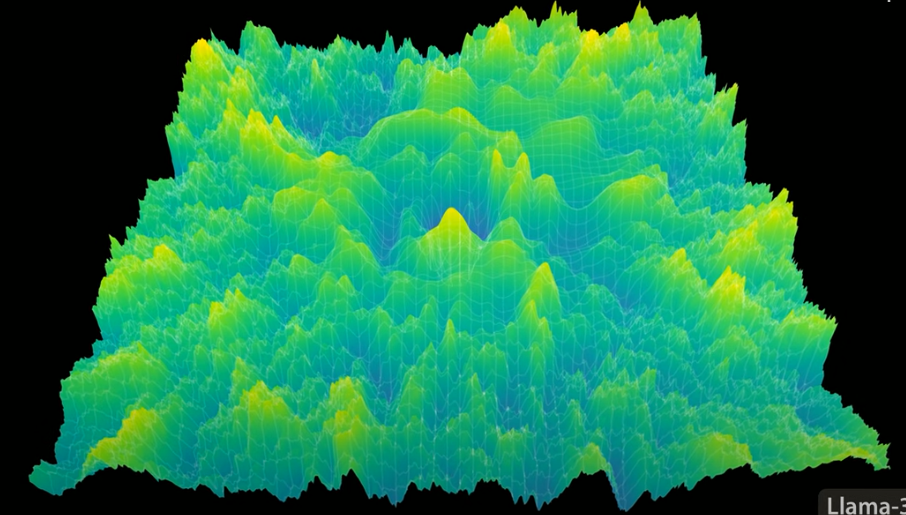

This is the loss space. Here we are trying to find a minimum for the loss function with our chosen training algorithm

image: https://www.youtube.com/watch?v=NrO20Jb-hy0

## The problem we try to fix

The exploding and vanishing gradient problems are common issues encountered when training deep neural networks.

1. Vanishing Gradient Problem: This occurs when gradients become extremely small as they propagate backward through many layers. This makes the updates to the weights in the earlier layers very small, effectively preventing them from learning.

2. Exploding Gradient Problem: This is the opposite of the vanishing gradient problem. Gradients become extremely large, leading to very large updates to the weights. This can cause the training process to become unstable and the model's performance to deteriorate rapidly.

These problems can make training deep networks challenging and require specific techniques to mitigate.

In a 2010 fundamental paper the causes of these two flaws of DNN training process were pointed to be mainly two:
1. the **saturation** of the activation function. Take for example the sigmoid function - historically on of the first activation functions used on neural networks - if it takes values to near to zero or one its derivative will be almost equal to zero, meaning that the overall gradient of the loss function will be near zero. This will yield no updates at all in the parameters of the net - we assume to use Gradient Descent as training algorithm - stopping the training.
2. the **variance difference** between the input and output of a layer. If this difference is positive, the gradient of the loss function could explode, making the parameters updates too big. This means that we will never settle to optimal values for them.

But not everything is lost, in the same paper some solutions were provided:
1. changing the activation function (relu was the first one)
2. regularizing the output of a layer to have variance equal to its input (batch normalization is commonly used for this purpose)
3. Finding a better inizialization for the parameters in the net. The idea is that if we can start from an educated guess value for them, the training will cinverge to a better overall solution

From here on, we reccomend to check out the notes on this topic. Only the code will be shown.

### Initialization

In [ ]:
import keras

In [ ]:
# he normal initialization
layer = keras.layers.Dense(10, activation = "relu", kernel_initializer=keras.initializers.he_normal())

In [ ]:
# LeCun initialization
layer = keras.layers.Dense(10, activation = "relu", kernel_initializer=keras.initializers.LecunNormal())

In [ ]:
# Glorot Normal
layer = keras.layers.Dense(10, activation = "relu", kernel_initializer=keras.initializers.GlorotNormal())

### Activation Functions

In [ ]:
# sigmoid: the old faithful
layer = keras.layers.Dense(10, activation = keras.activations.sigmoid(), kernel_initializer=keras.initializers.he_normal())

In [ ]:
# softmax: multiclass classification
layer = keras.layers.Dense(10, activation = "softmax", kernel_initializer=keras.initializers.he_normal())

In [ ]:
# relu activation: general purpose choice, fast to compute
layer = keras.layers.Dense(10, activation = "relu", kernel_initializer=keras.initializers.he_normal())

The vanishing ReLU problem occurs when ReLU neurons get stuck in a state where they output zero and their gradients are zero, preventing them from contributing to the learning process.

In [ ]:
# leaky relu: general purpose choice, solves the vaninshing relu problem
# the negative_slope parameter is tipically set to 0.01
# in keras its default is 0.2
layer = keras.layers.Dense(10, activation = "leaky_relu")

In [ ]:
# elu: experimentally outperforms relu and leaky relu, though takes more time to compute
# alpha is usually set to 1
layer = keras.layers.Dense(10, activation = "elu")

In [ ]:
# selu: scaled elu variant
# may trigger self-normalization effect under proper conditions
# automatically fuxes the exploding/vanishing gradient problem
layer = keras.layers.Dense(10, activation = "selu")

**Working**

Basically, the SELU activation function multiplies scale (> 1) with the output of the keras.activations.elu function to ensure a slope larger than one for positive inputs.
The values of alpha and scale are chosen so that the mean and variance of the inputs are preserved between two consecutive layers as long as the weights are initialized correctly.
Alpha and scale are pre-defined constants (alpha=1.67326324 and scale=1.05070098).

**Correct initialization**

1. standardize input features (mean zero and standard deviation one)
2. LeCun normal initialization
3. Sequential network architecture

In [ ]:
# correct selu initialization
input_layer = keras.layers.InputLayer(input_shape=(28,28))
layer1 = keras.layers.Dense(10, activation = "selu", kernel_initializer=keras.initializers.LecunNormal())
model = keras.models.Sequential([
    input_layer,
    layer1
])
model.summary()

In [ ]:
model.weights

Also versions of the layer with the chosen activation function are implemented within keras. They can be directly added to the sequential network object created.

In [ ]:
model = keras.models.Sequential()
# these layers will take the activation of the previous layer and apply to it the relu function
model.add(keras.layers.ReLU())
model.add(keras.layers.Softmax())

### Batch Normalization

Batch Normalization is implemented in Keras as a layer, meaning that it will perform an operation on any input signal it will process. So if you want to apply batch nomalization to the output of the activation function of a layer, just place a `BatchNormal` layer after the layer the output you want to normalize

In [ ]:
from sklearn.datasets import fetch_openml
X,y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [ ]:
from sklearn.model_selection import train_test_split
X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=10000)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
X_train_red = pca.fit_transform(X_train)
X_test_red = pca.fit_transform(X_test)

In [ ]:
y_train_int = y_train.astype(int)
y_test_int = y_test.astype(int)

In [ ]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = X_train_red.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation = "elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

In [ ]:
model.compile(optimizer="adam", loss = keras.losses.SparseCategoricalCrossentropy(), metrics = ["accuracy"])


In [ ]:
history = model.fit(X_train_red, y_train_int, epochs = 10, validation_split = 0.1)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

### Gradient Clipping

Gradient clipping is a technique used in neural network training to prevent the gradients from becoming too large. Large gradients can lead to unstable training and exploding gradients. Clipping the gradients ensures that their values stay within a reasonable range.

In [ ]:
# the learning |lr| < clipvalue
optimizer = keras.optimizers.SGD(clipvalue = 0.1)
model.compile(loss="mse", optimizer=optimizer)

### Transfer Learning

Deep learning models learn hierarchical representations of data. Early layers in a convolutional neural network (CNN) might learn basic features like edges and corners, while deeper layers learn more complex patterns specific to the training data. Transfer learning utilizes these learned early-stage features, which are often transferable across different visual tasks.

Benefits:

1. Reduced Training Time: Training from scratch can take a long time, especially with large DNNs and limited computational resources. Transfer learning significantly reduces training time.
2. Less Data Needed: Since the model already has a good starting point, it requires less data to achieve good performance on the new task compared to training from scratch.
3. Improved Performance: The pre-trained model has often learned robust and generalizable features, leading to better performance on the new task.

In [ ]:
model_A = keras.models.load_model("my_model.h5")
model_B_on_A = keras.models.Sequantial(model.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

### Faster Training Algorithms

Check out the documentation (https://keras.io/api/optimizers/) and the notes for further detalils

In [ ]:
# SGD: the old faithful
optimizer = keras.optimizers.SGD()
# RMSPROP
optimizer = keras.optimizers.RMSprop()
# ADAGRAD: too slow for training DNN
optimizer = keras.optimizers.Adagrad()
# Adam: the new Old Faithful
# Beta1 = 0.9, Beta2 = 0.999
optimizer = keras.optimizers.adam()
# Nadam: Adam + Nesterov accelerated gradient: faster than Adam
optimizer = keras.optimizers.Nadam()

### Regularization: l1 and l2

In [ ]:
layer = keras.layers.Dense(100, activation = "elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer = keras.regularizers.l1(0.01))

layer = keras.layers.Dense(100, activation = "elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer = keras.regularizers.l2(0.01))

### Regularization: Dropout

Just add a Dropout layer, that deactivates (sets to 0) on average a fraction of p outputs of the previous layer. This has the effect of deactivating some of the neurons in the next layer, thus making the DNN more robust, achieving these regularization effect.

In [ ]:
# the p of above. This quantity is referred as dropout probability
dropout_layer = keras.layers.Dropout(rate = 0.3)

## Further Readings:
- Razvan Pascanu - *On the difficulty of training RNN* - Shows an application of gradient clipping
- Gunter Klambauer t al. - *Self-normalizing Neural Networks* - In this article the SeLU activation function is for the first time exposed. In the same article it is also shown how to set a DNN to trigger a srlf-normalizing behavior
- Good and Bengio - *Understanding the difficulty of training deep forward neural networks* - The vanishing/explodent gradient problem is for the first time analysed and fully understood
- Ioffe and Szegedy - *Batch Normalization: accelerating deep network training by reducing internal covariate shift* - Exposes how and why batch-normalization should be used in training a DNN
- Smith - *A disciplined approach to neural-networ hyperparameters* - explores early techniques for recognizing overfitting or underfitting in a few epochs. Also the 1Cyvle learning schedule is exposed
- Hinton - *Improving Neural Networks by preventing Co-Adaptation of feature detectors* - Dropout learning is introduced (Also check out Srivastava *Dropout: A simple way to prevent neural networks form overfitting*)

## Takeaway DNN configurations

Default DNN configuration

| Hyperparameter | Default Value |
|---|---|
| Weight and bias initializer | He initialization |
| Activation Function | ELU |
| Normalization | None if shallow, Batch Norm if Deep |
| Optimizer | Momentum Optimization (or RMSProp or ADAM) |
| Regularization | Early Stopping (and l2 reg. if needed) |
| Learing Rate schedule | 1Cycle |

Self-normalizing DNN

| Hyperparameter | Default Value |
|---|---|
| Weight and bias initializer | LeCun initialization |
| Activation Function | SELU |
| Normalization | None (Self-Normalizing) |
| Optimizer | Momentum Optimizaiton (or RMSProp or ADAM) |
| Regularization | alpha droput if needed |
| Learing Rate schedule | 1Cycle |

## Graphs of activation functions

ReLU

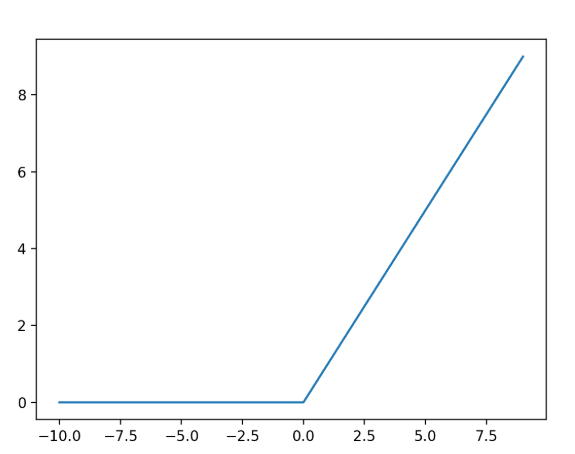

Leaky ReLU

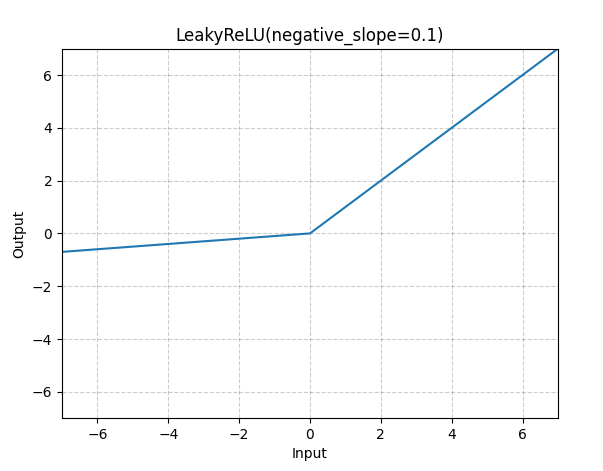

Elu

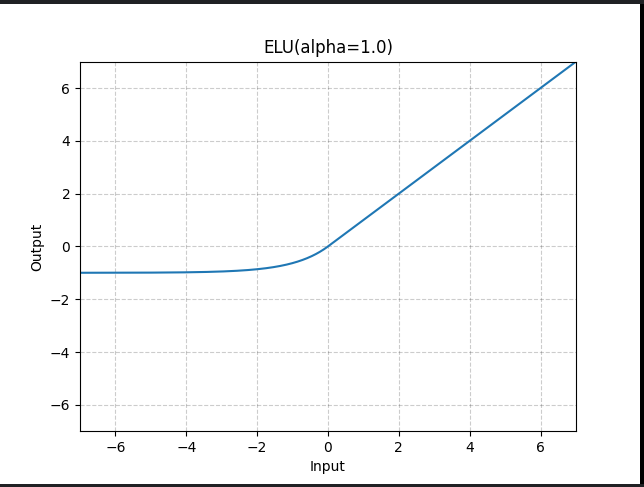

SeLU

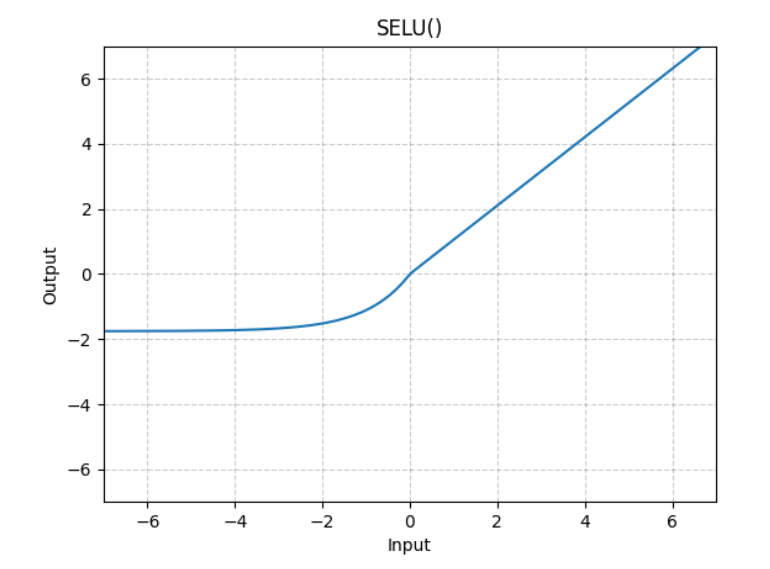

Tanh

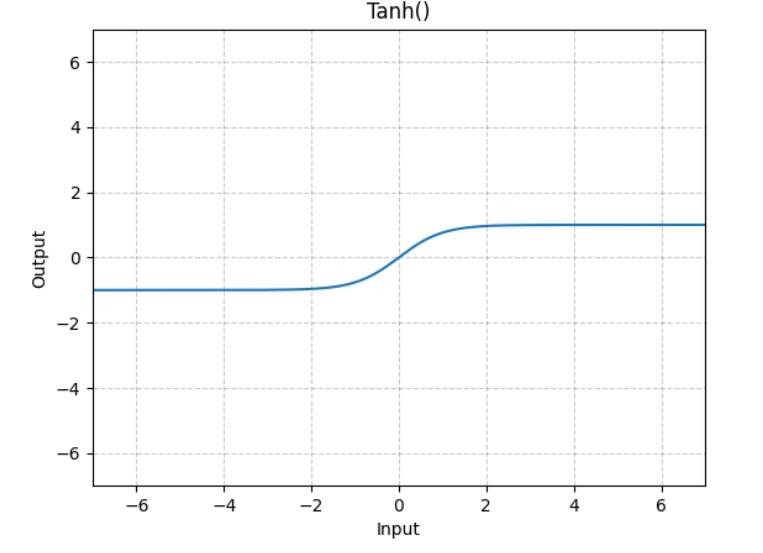

Logistic/Sigmoid

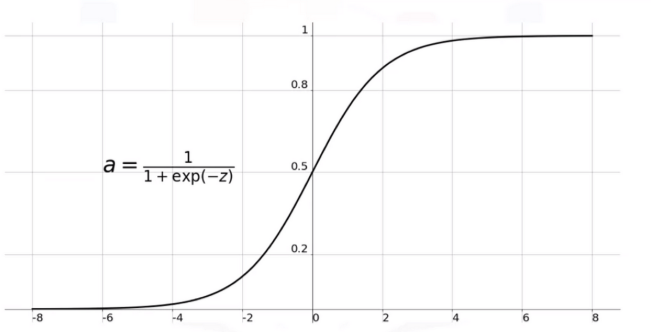

# Exercises

1. Is it OK to initialize all the weights to the same value as long as that value is selected randomly using He initialization?



No, initializing all weights to the same value, even with He initialization, is not okay for a neural network.

The main problems that will arise are:
- **Symmetry problem**: if all weights are initialized to the same value, every neuron in a layer will perform the exact same calculations during the forward pass. During backpropagation, all neurons will receive the same gradient and thus update their weights by the same amount. This means the neurons will remain identical throughout training, effectively reducing the network's capacity to learn complex patterns. It's like having multiple copies of the same neuron instead of distinct ones.
- **Need for Asymmetry**: He initialization, or any other proper initialization method, is designed to break this symmetry by initializing weights to small, random values. This ensures that neurons in the same layer start with slightly different initial states, leading to different calculations and distinct updates during training. This asymmetry is crucial for the network to learn diverse features and representations.

2. Is it OK to initialize the bias term to zero?

It is okay to initialize them at zero. Infact the bias terms are:
- easily optimmized: duing backpropragation the relative updating gradient is computed with respect to the respective layer activation
- don't generate asymmetri problems as long as the weights are trained correctly


While initializing biases to small random values is also sometimes done, initializing them to zero is a common and often effective practice. There are some cases where initializing biases to a small positive value might be beneficial, particularly with certain activation functions like ReLU, to help prevent "dead neurons" early in training. However, initializing to zero is a safe and widely used default.

3. Name three advantages of the SELU activation function over RELU

The SELU activation function, even if it is slower to compute than classic RELU, has some advantager over it. The main reasons why one should use it are:
- It can trigger self-normalization of the outuput of the net, if the network is properly set, thus solving the vanishing gradient problem
-  It always has non-zero derivative, fixing the dying ReLU problem
- It can take negative values, so the average output of the neurons in any layer is closer to zero, helping reducing the vanishing gradient problem

4. In which cases would you want to use each of the following activation functions: SELU, Leaky ReLU, ReLU, tanh, logistic and softamx?

SELU generally outperforms both ReLu and Leaky ReLU, but it generally requires more computational power both in training and predicting. Leaky ReLU and ReLU are good standards, the first one can fix fix the dying ReLU problem, so it has to be generally preferred over the other. ReLU is simple both to nuderstand and use, so it is a good Old Faithful activation function. It can be used as part of exploratory analysis over the data, since it is computationally efficient.

The last three activation functions: logistic, softmax and tanh are mainly used in the output layer, to set our net to perform in specific use cases and are rarely used in hidden layers. Logistic is used when we want to output a probability for a binary classification problem, while softmax is used un multiclassification problems. Eventually, tanh is used if we want our output to be a number between 1 and -1.

5. What may happen if the `momentum` hyperparameter is set to 0.9999 in the SGD algorithm?

In this case we would have that the updating process would get speed very fast, but the momentum it gains will eventually overshoot the minimum, slowing it down while it goeas back and forth until the momentum decreases. Something lie this would happen:

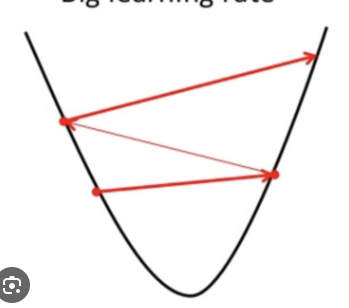

6. Practice training a deep neural network on the CIFAR10 dataset

In [ ]:
import tensorflow.keras as keras

In [ ]:
import numpy as np

In [ ]:
# data
# 60000 images of 32x32 pixel color images with 10 classes
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [ ]:
x_train.shape()

In [ ]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes

In [ ]:
def plot_image(image, label):
  plt.imshow(image)
  plt.title(labels[int(label)])
  plt.axis('off')

In [ ]:
plot_image(x_train[11], y_train[11])

In [ ]:
# A
# build a dnn with 20 hidden layers of 100 neurons each
# with elu activation and he initialization

# model building
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [32,32,3], name="Input")
])

for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

model.add(keras.layers.Dense(10, activation = "softmax"))

In [ ]:
model.summary()

In [ ]:
# model compilation
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
# using tensorboard
import os
root_logdir = os.path.join(os.curdir, "my_logs") # path to the my_logs folder

# function to create folders with a specified name in my_logs folder
def get_run_logdir():
  import time
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
  return os.path.join(root_logdir, run_id)

# create the training data folder in the my_log folder
run_logdir = get_run_logdir()

In [ ]:
# model training
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(x_train, y_train,
                  epochs = 20,
                  validation_split = 0.2,
                  callbacks = [tensorboard_cb])

In [ ]:
# launch the tensorboard server
# dynamical viualization of the training
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=606

In [ ]:
# Adding Batch Normalization
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
model.summary()

In [ ]:
# create the training data folder in the my_log folder
run_logdir1 = get_run_logdir()

# callbacks
early_stopping = keras.callbacks.EarlyStopping(patience = 20)
tb = keras.callbacks.TensorBoard(run_logdir1)

# model training
model.fit(x_train, y_train, epochs = 20, validation_split=0.2, callbacks=[tb, early_stopping])

In [ ]:
# launch the tensorboard server
# dynamical viualization of the training
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=606

In [ ]:
# replacing batch normalization with SELU
# creating the model
# we want to trigger the self-normalization effect so we will use the receipt described above
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation= "selu", kernel_initializer=keras.initializers.LecunNormal()))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
model.summary()

In [ ]:
# input features standardization
x_means = x_train.mean(axis=0)
x_stds = x_train.std(axis=0)
x_train_scaled = (x_train - x_means) / x_stds
x_test_scaled = (x_test - x_means) / x_stds

In [ ]:
# create the training data folder in the my_log folder
run_logdir1 = get_run_logdir()

# callbacks
early_stopping = keras.callbacks.EarlyStopping(patience = 20) # stops after 20 iterations with almost null improvement to the loss function
tb = keras.callbacks.TensorBoard(run_logdir1)

# model training
model.fit(x_train, y_train, epochs = 20, validation_split=0.2, callbacks=[tb, early_stopping])

In [ ]:
# launch the tensorboard server
# dynamical viualization of the training
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=607

If a self-normalizing network like the last one needs normalization, regular dropout cannot be applied, because it doesn't preserve the scale of its input. A variant of it exists that preserve the normalization of the inputs. This one is called alpha dropout, and it is designed to work specifically with self-normalizing networks.

Basically, it works like regular dropout, with an eye on preserving the mean and standard deviation of its inputs, thus not breaking self-normalization.

In [ ]:
# using alpha normalization
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))
# model compiling
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

model.summary()

In this case we decided to use dropout only with the output of the last hidden layer. Many state-of-the-art architectures work like this, it is an alternative it could be worth giving a shot, when full-dropout (dropout after each layer) is too strong (meaning that it slow too much the trianing).

In [ ]:
model.fit(x_train_scaled, y_train, epochs=100,
          validation_split = 0.2,
          callbacks=early_stopping)